## Configuration Spark

In [1]:
import socket

def check_port(host, port):
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(5)  # Timeout de 5 secondes
    result = sock.connect_ex((host, port))
    if result == 0:
        print(f"Connexion réussie à {host}:{port}")
    else:
        print(f"Impossible de se connecter à {host}:{port}")
    sock.close()

check_port("kafka1", 9092)


Connexion réussie à kafka1:9092


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")
 

sc = SparkContext.getOrCreate(conf=conf)


# Créer un SQLContext pour les opérations SQL
sql_context = SQLContext(sc)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6dfb1719-6399-4645-af4b-f6998bdcb3a3;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 44424)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/opt/conda/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.12/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/pyspark/accumulators.p

## Imports

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, count, window, avg, to_timestamp, min, max, last, broadcast, current_timestamp
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, DoubleType, BooleanType

## Schémas et Topics


In [4]:
kafka_broker = "kafka1:9092"
arrets_topic = "arrets"
velos_topic = "velos"
relais_topic = "relais"

# Définition du schéma pour le topic "arrets"
schema_arrets = StructType([
    StructField("codeLieu", StringType()),
    StructField("libelle", StringType()),
    StructField("distance", FloatType()),
    StructField("ligne", StringType())
])

# Définition du schéma pour le champ "position"
position_schema = StructType([
    StructField("lon", DoubleType()),
    StructField("lat", DoubleType())
])

# Définition du schéma pour le topic "velos"
schema_velos = StructType([
    StructField("number", StringType()),
    StructField("name", StringType()),
    StructField("address", StringType()),
    StructField("position", position_schema),
    StructField("banking", StringType()),
    StructField("bonus", StringType()),
    StructField("status", StringType()),
    StructField("contract_name", StringType()),
    StructField("bike_stands", IntegerType()),
    StructField("available_bike_stands", IntegerType()),
    StructField("available_bikes", IntegerType()),
    StructField("last_update", StringType())
])

# Définition du schéma pour le topic "relais"
schema_relais = StructType([
    StructField("grp_identifiant", StringType()),
    StructField("grp_nom", StringType()),
    StructField("grp_statut", IntegerType()),
    StructField("grp_disponible", IntegerType()),
    StructField("grp_exploitation", IntegerType()),
    StructField("grp_complet", IntegerType()),
    StructField("grp_horodatage", StringType()),
    StructField("idobj", StringType()),
    StructField("location", StructType([
        StructField("lon", DoubleType()),
        StructField("lat", DoubleType())
    ])),
    StructField("disponibilite", DoubleType())
])

# Définition du schéma pour le topic "relais"
schema_parking_public = StructType([
    StructField("grp_identifiant", StringType(), True),
    StructField("grp_nom", StringType(), True),
    StructField("grp_statut", StringType(), True),
    StructField("grp_disponible", IntegerType(), True),
    StructField("grp_exploitation", IntegerType(), True),
    StructField("grp_complet", IntegerType(), True),
    StructField("grp_horodatage", StringType(), True),
    StructField("idobj", StringType(), True),
    StructField("location", StructType([
         StructField("lon", DoubleType(), True),
         StructField("lat", DoubleType(), True)
    ]), True)
])

## Requête Batch sans fenêtre

Comptage des arrêts par ligne à partir du topic « arrets »

In [5]:
# Lecture brute des messages Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", arrets_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du champ "value" (encodé en JSON) en colonnes structurées
df_arrets = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_arrets).alias("data")) \
    .select("data.*")

# Agrégation : compter le nombre d'arrêts par "ligne"
result = df_arrets.groupBy("ligne").agg(count("*").alias("nb_arrets"))

# Affichage du résultat
result.show()
result.describe().show()

25/02/18 20:57:45 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+--------------------+---------+
|               ligne|nb_arrets|
+--------------------+---------+
| [{"numLigne":"79"}]|        6|
| [{"numLigne":"30"}]|       12|
| [{"numLigne":"91"}]|       14|
| [{"numLigne":"80"}]|       10|
|[{"numLigne":"172...|        2|
|[{"numLigne":"119...|        7|
|[{"numLigne":"75"...|        6|
| [{"numLigne":"C3"}]|       12|
|[{"numLigne":"101...|        2|
|[{"numLigne":"152...|        1|
|[{"numLigne":"1"}...|        1|
|[{"numLigne":"59"...|        3|
|[{"numLigne":"50"...|        4|
|[{"numLigne":"30"...|        7|
|[{"numLigne":"104...|        1|
|[{"numLigne":"107...|        3|
|[{"numLigne":"1"}...|        1|
|[{"numLigne":"102...|        3|
|[{"numLigne":"127...|        2|
|[{"numLigne":"105...|        4|
+--------------------+---------+
only showing top 20 rows



25/02/18 20:57:53 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------+--------------------+-----------------+
|summary|               ligne|        nb_arrets|
+-------+--------------------+-----------------+
|  count|                 434|              434|
|   mean|                NULL|2.686635944700461|
| stddev|                NULL|3.224968441931373|
|    min|                  []|                1|
|    max|[{"numLigne":"NBI"}]|               28|
+-------+--------------------+-----------------+



Analyse des stations de vélo par statut historique

In [6]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import Window

spark = SparkSession.builder.appName("BikeHistory").getOrCreate()

# --- Helper function: read_kafka_stream ---
def read_kafka_stream(topic, schema, is_streaming=True):
    if is_streaming:
        df = spark.readStream.format("kafka") \
            .option("kafka.bootstrap.servers", kafka_broker) \
            .option("subscribe", topic) \
            .option("startingOffsets", "earliest") \
            .load()
    else:
        df = spark.read.format("kafka") \
            .option("kafka.bootstrap.servers", kafka_broker) \
            .option("subscribe", topic) \
            .option("startingOffsets", "earliest") \
            .load()
    # Convert the binary "value" column to string and parse JSON using the provided schema.
    df = df.selectExpr("CAST(value AS STRING) as json_string")
    df = df.select(F.from_json(F.col("json_string"), schema).alias("data")).select("data.*")
    return df

# Read batch data from the "velos" topic (is_streaming=False)
df_velos = read_kafka_stream("velos", schema_velos, is_streaming=False).where(F.col("status").isNotNull())

# Perform aggregation by 'status'
result_batch1 = df_velos.groupBy("status") \
    .agg(
        F.count("*").alias("total_stations"),
        F.avg("available_bikes").alias("moyenne_velos_dispos"),
        F.stddev("available_bikes").alias("ecart_type_velos")
    ) \
    .withColumn("pourcentage", F.col("total_stations") / F.sum("total_stations").over(Window.partitionBy())) \
    .orderBy(F.desc("total_stations"))

result_batch1.show()


25/02/18 20:58:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/02/18 20:58:37 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 20:58:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/18 20:58:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/18 20:58:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/18 20:58:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/18 20:58:38 WARN 

+------+--------------+--------------------+-----------------+-----------+
|status|total_stations|moyenne_velos_dispos| ecart_type_velos|pourcentage|
+------+--------------+--------------------+-----------------+-----------+
|  OPEN|          1372|   8.208454810495628|6.437852023428619|       0.98|
|CLOSED|            28|                 0.0|              0.0|       0.02|
+------+--------------+--------------------+-----------------+-----------+



## Requête Batch avec fenêtre

Vélos disponibles par contrat sur des fenêtres temporelles à partir du topic « velos ».
Malheuresement on a qu'une donnée par station donc ca permet pas de faire de l'aggrégation comme la moyenne de vélo sur la période..... faut essayer de trouver des données plus pertinentes.

In [7]:
# Lecture brute des messages Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du champ "value" en JSON
df_velos = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion de "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Agrégation par fenêtre (ici, on allonge la fenêtre à 30 minutes pour accumuler plusieurs mises à jour) et par station
result_window = df_velos.groupBy(
    window(col("last_update_ts"), "30 minutes"), 
    col("number"),
    col("contract_name")
).agg(
    count("*").alias("nb_updates"),
    last("available_bikes", ignorenulls=True).alias("latest_available_bikes")
)

result_window.show()

## Requête Batch avec visualisation

Graphique des totaux de stations par statut avec Pandas et Seaborn

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas for visualization
pdf = result_batch1.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(data=pdf, x="status", y="total_stations", palette="viridis")
plt.title("Total des stations de vélo par statut")
plt.xlabel("Statut")
plt.ylabel("Nombre total de stations")
plt.show()


## Requêtes Streaming

### Récuperer la moyenne des disponiblités des parkings relais sur une fenêtre glissante.

In [ ]:
# Lecture en streaming depuis Kafka
df_kafka = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", relais_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_relais = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_relais).alias("data")) \
    .select("data.*")

# Conversion du champ "grp_horodatage" en timestamp
# Le format ISO 8601 est utilisé : "yyyy-MM-dd'T'HH:mm:ssXXX"
df_relais = df_relais.withColumn("horodatage_ts", 
                                  to_timestamp(col("grp_horodatage"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Définition d'un watermark de 5 minutes pour gérer les retards éventuels
df_relais = df_relais.withWatermark("horodatage_ts", "5 minutes")

# Agrégation : calcul de la moyenne des disponibilités sur une fenêtre glissante
# Ici, la fenêtre est de 5 minutes et on agrège par "grp_identifiant"
result_stream = df_relais.groupBy(
    window(col("horodatage_ts"), "5 minutes"),
    col("grp_identifiant"),
).agg(
    avg("disponibilite").alias("avg_disponibilite")
)

# Écriture du résultat en streaming vers la console (mode "update")
query = result_stream.writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query.awaitTermination()

In [ ]:
query.stop()

### Récuperer la moyenne des vélos disponibles par parking sur une fenêtre glissante.

In [ ]:
# Lecture en streaming depuis Kafka
df_kafka_velos = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_velos = df_kafka_velos.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion du champ "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Application d'un watermark de 5 minutes pour gérer les retards
df_velos = df_velos.withWatermark("last_update_ts", "5 minutes")

# Agrégation sur une fenêtre de 5 minutes : calcul du total des places disponibles
result_velos = df_velos.groupBy(
    window(col("last_update_ts"), "5 minutes"),
    col("name")
).agg(
    avg("available_bikes").alias("moyenne_velos_disponibles")
)

# Écriture du résultat en streaming vers la console (mode "update")
query_velos = result_velos.writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query_velos.awaitTermination()

In [ ]:
query_velos.stop()

## Multimodal query

Define the Haversine Function and UDF

In [23]:
from pyspark.sql import functions as F
from math import radians, sin, cos, sqrt, atan2

# 1. Define Python function
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 6371 * 2 * atan2(sqrt(a), sqrt(1-a))  # Earth radius in km

# 2. Create Spark UDF
haversine_udf = F.udf(haversine, DoubleType())

# 3. Register for SparkSQL
spark.udf.register("haversine", haversine_udf)

25/02/18 21:28:31 WARN SimpleFunctionRegistry: The function haversine replaced a previously registered function.


In [24]:
# 1. Read data and create temporary views
df_arrets = read_kafka_stream(arrets_topic, schema_arrets, is_streaming=False)
df_velos = read_kafka_stream(velos_topic, schema_velos, is_streaming=False)
df_relais = read_kafka_stream(relais_topic, schema_relais, is_streaming=False)
df_parking = read_kafka_stream("parking_public", schema_parking_public, is_streaming=False)

In [25]:
# Check record counts at each stage
print("Parking Count:", df_parking.count())  # Should be >0
print("Velos Count:", df_velos.count())      # Should be >0
print("Relais Count:", df_relais.count())    # Should be >0

# Check non-full parkings
non_full = df_parking.filter(F.col("grp_complet") != 1)
print("Non-Full Parkings:", non_full.count())

25/02/18 21:28:41 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Parking Count: 580


25/02/18 21:28:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 21:28:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Velos Count: 2000
Relais Count: 380


25/02/18 21:28:43 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Non-Full Parkings: 580


Section 1: Batch Query – Aggregated Multimodal Connectivity Hubs

In [ ]:
# Final Corrected Batch Request with Proper Syntax and Names
parking_bike_analysis = (
    df_parking.alias("parking")
    .filter(F.col("parking.grp_complet") != 1)
    .join(
        df_velos.alias("velo"),
        [
            (F.abs(F.col("parking.location.lon") - F.col("velo.position.lon")) <= 0.01),
            (F.abs(F.col("parking.location.lat") - F.col("velo.position.lat")) <= 0.01)
        ]
    )
    .withColumn("distance_km", haversine_udf(
        F.col("parking.location.lon"), 
        F.col("parking.location.lat"),
        F.col("velo.position.lon"),
        F.col("velo.position.lat")
    ))
    .filter(F.col("distance_km") <= 0.5)
    .groupBy("parking.grp_identifiant")
    .agg(
        F.avg("velo.available_bikes").alias("avg_bikes"),
        F.count_distinct("velo.number").alias("nearby_stations"),
        F.first("parking.location.lon").alias("parking_lon"),
        F.first("parking.location.lat").alias("parking_lat"),
        F.first("parking.grp_nom").alias("parking_grp_nom")  # Get parking's own name
    )
    .join(
        df_relais.alias("relais"), 
        "grp_identifiant", 
        "left"
    )
    .select(
        F.coalesce(
            "relais.grp_nom", 
            "parking_grp_nom", 
            F.concat(F.lit("Parking "), "grp_identifiant")
        ).alias("location_name"),  # Fixed parenthesis and alias position
        "avg_bikes",
        "nearby_stations",
        F.coalesce("relais.location.lon", "parking_lon").alias("lon"),
        F.coalesce("relais.location.lat", "parking_lat").alias("lat")
    )
)

parking_bike_analysis.show(truncate=False)

25/02/18 21:31:41 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 21:31:41 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 21:31:41 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----------------------+------------------+---------------+-------------------+------------------+
|location_name         |avg_bikes         |nearby_stations|lon                |lat               |
+----------------------+------------------+---------------+-------------------+------------------+
|Feydeau               |5.710424710424711 |15             |-1.552558781000016 |47.21407529499999 |
|Decré-Bouffay         |8.141975308641975 |17             |-1.5540046290000191|47.21666261299998 |
|Tour Bretagne         |9.921282798833818 |20             |-1.5582500169999776|47.21784288800001 |
|Graslin               |10.280788177339902|12             |-1.562571814000023 |47.214310205000004|
|Aristide Briand       |12.55299539170507 |13             |-1.5629364160000137|47.21709359800002 |
|Médiathèque           |6.572463768115942 |9              |-1.56233817399999  |47.210870821000015|
|Commerce              |6.587719298245614 |14             |-1.557713217000014 |47.21312028       |
|Talensac 

In [32]:
# Rank parking relays by nearby bike availability
parking_ranking = (
    read_kafka_stream(relais_topic, schema_relais, False).alias("relais")
    .crossJoin(read_kafka_stream(velos_topic, schema_velos, False).alias("velo"))
    .withColumn("distance_km", haversine_udf(
        F.col("relais.location.lon"),
        F.col("relais.location.lat"),
        F.col("velo.position.lon"),
        F.col("velo.position.lat")
    ))
    .filter(F.col("distance_km") <= 0.5)
    .groupBy("relais.grp_identifiant", "relais.grp_nom")
    .agg(
        F.avg("velo.available_bikes").alias("avg_bikes"),
        F.count_distinct("velo.number").alias("num_stations")
    )
    .withColumn("rank", 
               F.dense_rank().over(Window.orderBy(F.desc("avg_bikes")))
    )
    .orderBy("rank")
)

parking_ranking.show(truncate=False)

25/02/18 21:57:50 WARN ExtractPythonUDFFromJoinCondition: The join condition:(haversine(location#4375.lon, location#4375.lat, position#4408.lon, position#4408.lat)#4451 <= 0.5) of the join plan contains PythonUDF only, it will be moved out and the join plan will be turned to cross join.
25/02/18 21:57:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 21:57:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 21:57:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/18 21:57:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance d

+---------------+-------------+------------------+------------+----+
|grp_identifiant|grp_nom      |avg_bikes         |num_stations|rank|
+---------------+-------------+------------------+------------+----+
|140            |P+R Huit Mai |13.551724137931034|2           |1   |
|144            |P+R Gréneraie|5.555555555555555 |2           |2   |
+---------------+-------------+------------------+------------+----+



In [40]:
from pyspark.sql.window import Window

# Assume df_velos and df_relais are loaded in batch mode (is_streaming=False)

relays_velos = (
    df_relais.alias("rel")
    .join(
        df_velos.alias("vel"),
        haversine_udf(
            F.col("rel.location.lon"),
            F.col("rel.location.lat"),
            F.col("vel.position.lon"),
            F.col("vel.position.lat")
        ) <= 1.0  # 1 km threshold
    )
    .groupBy("rel.grp_identifiant", "rel.grp_nom")
    .agg(
         F.avg("vel.available_bikes").alias("avg_available_bikes"),
         F.count("vel.number").alias("nearby_stations")
    )
)

window_spec = Window.orderBy(F.desc("avg_available_bikes"))
relays_ranked = relays_velos.withColumn("rank", F.dense_rank().over(window_spec))

relays_ranked.show(truncate=False)


25/02/18 22:26:36 WARN ExtractPythonUDFFromJoinCondition: The join condition:(haversine(location#2830.lon, location#2830.lat, position#2783.lon, position#2783.lat)#5638 <= 1.0) of the join plan contains PythonUDF only, it will be moved out and the join plan will be turned to cross join.
25/02/18 22:26:36 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 22:26:36 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 22:26:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/18 22:26:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance d

+---------------+--------------------+-------------------+---------------+----+
|grp_identifiant|grp_nom             |avg_available_bikes|nearby_stations|rank|
+---------------+--------------------+-------------------+---------------+----+
|152            |P+R Prairie de Mauve|12.028571428571428 |1225           |1   |
|139            |P+R Recteur Schmitt |7.230769230769231  |1820           |2   |
|140            |P+R Huit Mai        |7.117647058823529  |5355           |3   |
|144            |P+R Gréneraie       |6.698795180722891  |11620          |4   |
+---------------+--------------------+-------------------+---------------+----+



25/02/18 22:26:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/18 22:26:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/18 22:26:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [41]:
parking_velos_deficit = (
    df_parking.alias("parking")
    .filter(F.col("grp_complet") != 1)
    .join(
         df_velos.alias("velo"),
         (F.abs(F.col("parking.location.lon") - F.col("velo.position.lon")) <= 0.01) &
         (F.abs(F.col("parking.location.lat") - F.col("velo.position.lat")) <= 0.01)
    )
    .withColumn("bike_deficit", F.col("velo.bike_stands") - F.col("velo.available_bikes"))
    .groupBy("parking.grp_identifiant", "parking.grp_nom")
    .agg(
         F.avg("bike_deficit").alias("avg_bike_deficit"),
         F.sum("velo.available_bikes").alias("total_available_bikes")
    )
)

parking_velos_deficit.show(truncate=False)


25/02/18 22:27:40 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 22:27:40 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+---------------+----------------------+------------------+---------------------+
|grp_identifiant|grp_nom               |avg_bike_deficit  |total_available_bikes|
+---------------+----------------------+------------------+---------------------+
|009            |Cité des Congrès      |14.693854748603352|236145               |
|001            |Feydeau               |13.605828220858896|390530               |
|021            |Gare Nord             |14.316718587746625|261835               |
|040            |Fonderies             |15.081597222222221|108535               |
|006            |Médiathèque           |13.326660600545951|300125               |
|005            |Aristide Briand       |10.848252344416027|355565               |
|008            |Talensac              |10.047619047619047|376110               |
|016            |Gare Sud 2 : Limité 1h|15.580508474576272|191870               |
|002            |Decré-Bouffay         |12.278936017253775|360220               |
|044            

25/02/18 22:29:55 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 22:29:55 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


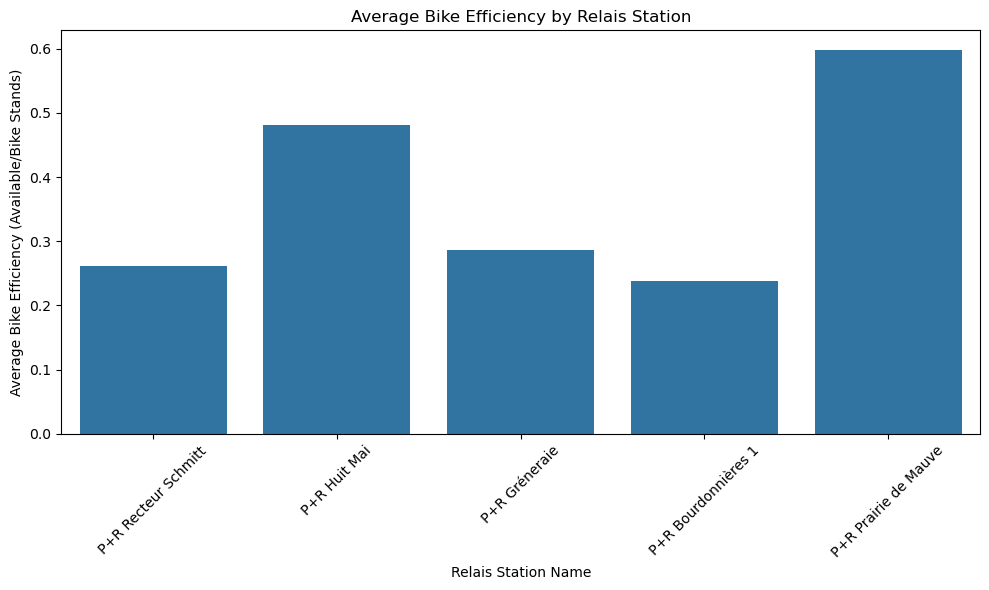

25/02/18 22:41:36 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-4b4b86b7-13c2-4219-939d-d80f72d0f1ea. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-4b4b86b7-13c2-4219-939d-d80f72d0f1ea
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:174)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimize

In [ ]:
relays_efficiency = (
    df_relais.alias("rel")
    .join(
         df_velos.alias("velo"),
         (F.abs(F.col("rel.location.lon") - F.col("velo.position.lon")) <= 0.01) &
         (F.abs(F.col("rel.location.lat") - F.col("velo.position.lat")) <= 0.01)
    )
    .withColumn("bike_efficiency", F.col("velo.available_bikes") / F.col("velo.bike_stands"))
    .groupBy("rel.grp_nom")
    .agg(F.avg("bike_efficiency").alias("avg_bike_efficiency"))
)

# Convert to Pandas for plotting
relays_efficiency_pd = relays_efficiency.toPandas()

# Example visualization using seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=relays_efficiency_pd, x="grp_nom", y="avg_bike_efficiency")
plt.title("Average Bike Efficiency by Relais Station")
plt.xlabel("Relais Station Name")
plt.ylabel("Average Bike Efficiency (Available/Bike Stands)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
